In [1]:
# Imports necessary to acquire, prepare, explore, visualize, analyze, and model data

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import prepare 

from tabulate import tabulate
from IPython.display import Markdown, display

from math import sqrt
from scipy import stats

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

np.random.seed(123)

In [2]:
df = acquire.get_zillow_data()

In [3]:
df = prepare.remove_outliers(df)

In [ ]:
df.info()

In [4]:
df = prepare.handle_nulls(df)

In [5]:
df = prepare.rename_columns(df)

In [6]:
df = prepare.prepare_locs(df)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47936 entries, 0 to 52440
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   47936 non-null  int64         
 1   bathrooms                  47936 non-null  float64       
 2   bedrooms                   47936 non-null  float64       
 3   square_feet                47936 non-null  int64         
 4   fips                       47936 non-null  int64         
 5   garages                    47936 non-null  int64         
 6   garage_size                47936 non-null  int64         
 7   lot_size                   47936 non-null  int64         
 8   has_pool                   47936 non-null  bool          
 9   propertycountylandusecode  47936 non-null  object        
 10  propertylandusetypeid      47936 non-null  float64       
 11  year_built                 47936 non-null  int64         
 12  taxv

In [8]:
train, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)
# Splits data into 3 subsets: train, validate, test. Random state specifying that data is split
# with the exact same records when the code is re-run (useful for exploration and modeling, yet
# I suggest dropping this when employing the model)

def printmd(string): # function to format text style
    display(Markdown(string))
print()
printmd('**Number of Train Records:** {:,}'
     .format(len(train)))
printmd('**Number of Validate Records:** {:,}'
     .format(len(validate)))
printmd('**Number of Test Records:** {:,}'
     .format(len(test)))
# returns the amount of records in each subset after splitting

**Number of Train Records:** 26,843

**Number of Validate Records:** 11,505

**Number of Test Records:** 9,588

In [9]:
orange_train = train.where(train.county == 'orange')
orange_validate = validate.where(validate.county == 'orange')
orange_test = test.where(test.county == 'orange')

In [10]:
orange_train = orange_train.dropna()
orange_validate = orange_validate.dropna()
orange_test = orange_test.dropna()

In [12]:
orange_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7368 entries, 50705 to 1588
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   7368 non-null   float64       
 1   bathrooms                  7368 non-null   float64       
 2   bedrooms                   7368 non-null   float64       
 3   square_feet                7368 non-null   float64       
 4   fips                       7368 non-null   float64       
 5   garages                    7368 non-null   float64       
 6   garage_size                7368 non-null   float64       
 7   lot_size                   7368 non-null   float64       
 8   has_pool                   7368 non-null   object        
 9   propertycountylandusecode  7368 non-null   object        
 10  propertylandusetypeid      7368 non-null   float64       
 11  year_built                 7368 non-null   float64       
 12  ta

In [13]:
continuous_features = orange_train[['bathrooms', 'bedrooms', 'square_feet', 'garages', 'garage_size', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'lot_size', 'year_built']]

In [14]:
discrete_features = orange_train[['has_pool', 'transaction_date', 'propertycountylandusecode']]

<AxesSubplot:title={'center':'Feature Correlation (contiuous variables) of to Log Error'}>

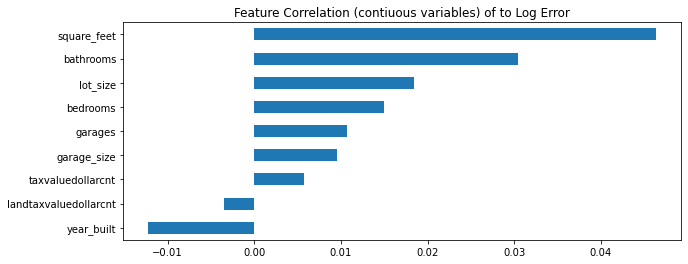

In [15]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation (contiuous variables) of to Log Error")
corr_chart = continuous_features.corrwith(orange_train['log_error']).sort_values().plot.barh()
corr_chart


- square feet, bathrooms, and year built - these 3 move on for modeling

In [ ]:
discrete_features

In [ ]:
orange_train

In [ ]:
import plotly.express as px

In [ ]:
sns.barplot(data=orange_train, x='propertycountylandusecode', y='log_error')
plt.title("Land Code w/Cont.")

In [ ]:
orange_train.propertycountylandusecode.value_counts()

In [ ]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='year_built', y='lot_size', data=orange_train, scatter=True, hue='propertycountylandusecode', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

In [ ]:
#log error for square foot less than 2000 in 122 is problem
#1960
#with 2-4 br

In [ ]:
(orange_train.where(orange_train.propertycountylandusecode == '122')).describe()

In [ ]:
(orange_train.where(orange_train.propertycountylandusecode == '1')).describe()

In [ ]:
orange_train.garages.value_counts()

Because there are so few properties that have 3+ garages, I'm turning this into a boolean of yes/no garage and dropping garage size.

In [16]:
orange_train['garages'] = orange_train.garages.astype(bool)

In [ ]:
orange_train.garages.value_counts()

In [ ]:
(orange_train.where(orange_train.propertycountylandusecode == '122')).groupby(orange_train.garages).sum()

pretty much all of the homes in code 1 have garages. 

In [17]:
orange_train_neg = orange_train.where(orange_train.log_error < 0)
orange_train_pos = orange_train.where(orange_train.log_error > 0)

In [ ]:
orange_train_neg.groupby(orange_train_neg.has_pool).mean()

In [ ]:
orange_train_neg.describe()

In [19]:
orange_train['has_pool'] = orange_train.has_pool.astype(int)
orange_train['garages'] = orange_train.has_pool.astype(int)

In [20]:
bins = [-.6, -.0475, -.0244, -.0106, 0, .0125, .0283, .0586, .6]
labels = ['N4','N3','N2','N1', 'P1', 'P2', 'P3', 'P4']
orange_train['log_error_bin'] = pd.cut(orange_train['log_error'], bins=bins, labels=labels)
orange_validate['log_error_bin'] = pd.cut(orange_validate['log_error'], bins=bins, labels=labels)
orange_test['log_error_bin'] = pd.cut(orange_test['log_error'], bins=bins, labels=labels)

In [21]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [25]:
orange_train_neg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7368 entries, 50705 to 1588
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   3052 non-null   float64       
 1   bathrooms                  3052 non-null   float64       
 2   bedrooms                   3052 non-null   float64       
 3   square_feet                3052 non-null   float64       
 4   fips                       3052 non-null   float64       
 5   garages                    3052 non-null   object        
 6   garage_size                3052 non-null   float64       
 7   lot_size                   3052 non-null   float64       
 8   has_pool                   3052 non-null   object        
 9   propertycountylandusecode  3052 non-null   object        
 10  propertylandusetypeid      3052 non-null   float64       
 11  year_built                 3052 non-null   float64       
 12  ta

In [ ]:
orange_train.groupby(orange_train.log_error_bin == 'N4').max()

In [22]:
bins = [0, .0125, .0283, .0586, .6]
labels = ['P1', 'P2', 'P3', 'P4']
orange_train_pos['log_error_bin'] = pd.cut(orange_train_pos['log_error'], bins=bins, labels=labels)

In [23]:
bins = [-.6, -.0475, -.0244, -.0106, 0.01]
labels = ['N4','N3','N2','N1']
orange_train_neg['log_error_bin'] = pd.cut(orange_train_neg['log_error'], bins=bins, labels=labels)

In [ ]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='year_built', y='log_error', data=orange_train, scatter=True, col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

In [ ]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='year_built', y='log_error', data=orange_train_pos, scatter=True, hue='log_error_bin', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

Text(0.5, 1.0, 'Square Footage Correlation (Grouped by Bin) to Log Error')

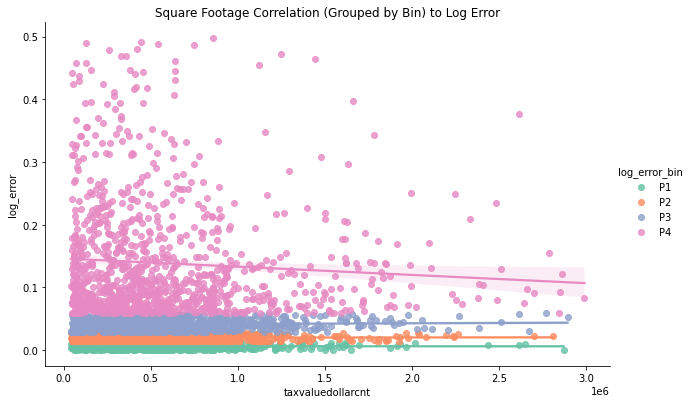

In [27]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='taxvaluedollarcnt', y='log_error', data=orange_train_pos, scatter=True, hue='log_error_bin', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

In [ ]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='lot_size', y='log_error', data=orange_train_pos, scatter=True, hue='log_error_bin', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

In [115]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='lot_size', y='log_error', data=pos_orange_train, scatter=True, hue='log_error_bin', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

NameError: name 'pos_orange_train' is not defined

In [28]:
orange_train = orange_train[orange_train.lot_size < 200000]
orange_validate = orange_validate[orange_validate.lot_size < 200000]
orange_test = orange_test[orange_test.lot_size < 200000]
orange_train_pos = orange_train_pos[orange_train_pos.lot_size < 200000]
orange_train_neg = orange_train_neg[orange_train_neg.lot_size < 200000]

In [ ]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='lot_size', y='log_error', data=orange_train_pos, scatter=True, hue='log_error_bin', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

<AxesSubplot:title={'center':'Feature Correlation to Churn'}>

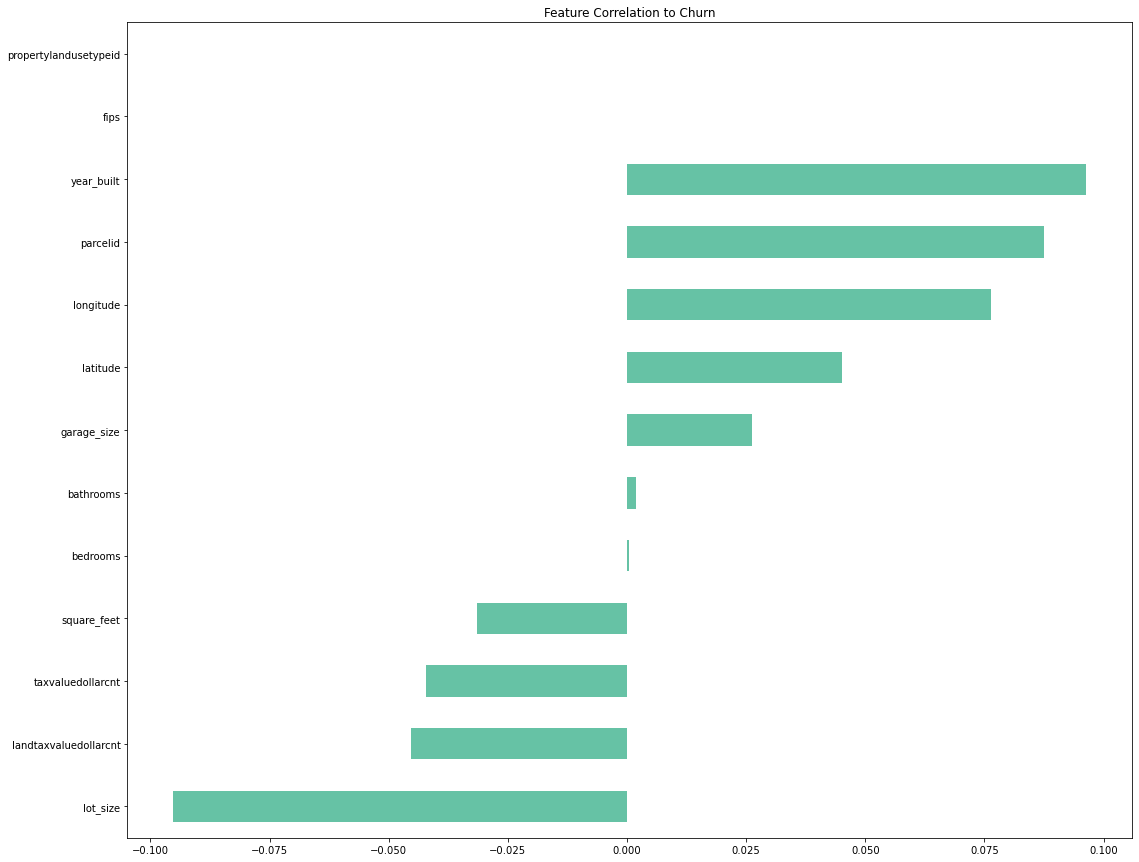

In [31]:
plt.figure(figsize=(18,15))
plt.title("Feature Correlation to Churn")
corr_chart = orange_train_neg.drop("log_error", axis=1).corrwith(orange_train_neg['log_error']).sort_values().plot.barh()
corr_chart

In [ ]:
orange_train['weight_lot'] = orange_train['lot_size'] * 3.5
orange_validate['weight_lot'] = orange_validate['lot_size'] * 3.5
orange_test['weight_lot'] = orange_test['lot_size'] * 3.5

In [ ]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(orange_train[['weight_lot', 'square_feet']])

In [ ]:
orange_train[['scallot', 'scalsquare']] = scaler.transform(orange_train[['weight_lot', 'square_feet']])

In [ ]:
orange_validate[['scallot', 'scalsquare']] = scaler.transform(orange_validate[['weight_lot', 'square_feet']])
orange_test[['scallot', 'scalsquare']] = scaler.transform(orange_test[['weight_lot', 'square_feet']])

In [ ]:
orange_train['sqft'] = (orange_train.scallot + orange_train.scalsquare) / 2
orange_validate['sqft'] = (orange_validate.scallot + orange_validate.scalsquare) / 2
orange_test['sqft'] = (orange_test.scallot + orange_test.scalsquare) / 2

In [ ]:
orange_train_neg = orange_train.where(orange_train.log_error < 0)
orange_train_pos = orange_train.where(orange_train.log_error > 0)

In [ ]:
datap1 = orange_train_pos[orange_train_pos.log_error_bin == 'P1']
datap2 = orange_train_pos[orange_train_pos.log_error_bin == 'P2']
datap3 = orange_train_pos[orange_train_pos.log_error_bin == 'P3']
datap4 = orange_train_pos[orange_train_pos.log_error_bin == 'P4']

In [ ]:
datan1 = orange_train_neg[orange_train_neg.log_error_bin == 'N1']
datan2 = orange_train_neg[orange_train_neg.log_error_bin == 'N2']
datan3 = orange_train_neg[orange_train_neg.log_error_bin == 'N3']
datan4 = orange_train_neg[orange_train_neg.log_error_bin == 'N4']

In [ ]:
dp1 = datap1[['bedrooms', 'bathrooms', 'sqft', 'square_feet', 'lot_size', 'year_built', 'log_error']]
dp2 = datap2[['bedrooms', 'bathrooms', 'sqft','square_feet', 'lot_size', 'year_built', 'log_error']]
dp3 = datap3[['bedrooms', 'bathrooms','sqft', 'square_feet', 'lot_size', 'year_built', 'log_error']]
dp4 = datap4[['bedrooms', 'bathrooms', 'sqft','square_feet', 'lot_size', 'year_built', 'log_error']]

In [ ]:
dn1 = datan1[['bedrooms', 'bathrooms','sqft', 'square_feet', 'lot_size', 'year_built', 'log_error']]
dn2 = datan2[['bedrooms', 'bathrooms', 'sqft','square_feet', 'lot_size', 'year_built', 'log_error']]
dn3 = datan3[['bedrooms', 'bathrooms', 'sqft','square_feet', 'lot_size', 'year_built', 'log_error']]
dn4 = datan4[['bedrooms', 'bathrooms', 'sqft','square_feet', 'lot_size', 'year_built', 'log_error']]

In [ ]:
data_pos = orange_train_pos[['bedrooms', 'sqft', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'log_error']]
data_neg = orange_train_neg[['bedrooms', 'sqft', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'log_error']]

In [ ]:
sns.pairplot(data_pos)

In [ ]:
sns.pairplot(dp3)

In [ ]:
sns.pairplot(dp4)

In [ ]:
sns.pairplot(dn4)

Log error- higher for having gargage
higher for 1 bedroom and bit higher for 5 beds
higher for 4 + bathrooms
before 1949 has higher log error
square feet - I think it's greater for small and big
very low for having a pool

not
-landusecode

In [ ]:
plt.figure(figsize=(18,15))
plt.title("Feature Correlation to Churn")
corr_chart = orange_train.drop("log_error", axis=1).corrwith(abs(orange_train['log_error'])).sort_values().plot.barh()
corr_chart

In [45]:
from sklearn.cluster import KMeans
import sklearn.preprocessing

In [32]:
orange_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7367 entries, 50705 to 1588
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   7367 non-null   float64       
 1   bathrooms                  7367 non-null   float64       
 2   bedrooms                   7367 non-null   float64       
 3   square_feet                7367 non-null   float64       
 4   fips                       7367 non-null   float64       
 5   garages                    7367 non-null   int64         
 6   garage_size                7367 non-null   float64       
 7   lot_size                   7367 non-null   float64       
 8   has_pool                   7367 non-null   int64         
 9   propertycountylandusecode  7367 non-null   object        
 10  propertylandusetypeid      7367 non-null   float64       
 11  year_built                 7367 non-null   float64       
 12  ta

In [46]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(orange_train[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'has_pool', 'garages', 'lot_size','year_built']])
# inserts the 4 selected features into the scaler

orange_train_s = (orange_train[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'has_pool', 'garages', 'lot_size','year_built']])
orange_validate_s  = (orange_validate[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'has_pool', 'garages', 'lot_size','year_built']])
orange_test_s = (orange_test[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'has_pool', 'garages', 'lot_size','year_built']])

orange_train_scal = scaler.transform(orange_train[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'has_pool', 'garages', 'lot_size','year_built']])
orange_validate_scal  = scaler.transform(orange_validate[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'has_pool', 'garages', 'lot_size','year_built']])
orange_test_scal  = scaler.transform(orange_test[['bedrooms', 'bathrooms', 'year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'has_pool', 'garages', 'lot_size','year_built']])

In [47]:
X_train_scaled = pd.DataFrame(orange_train_scal, index=orange_train_s.index, columns=orange_train_s.columns)
X_validate_scaled = pd.DataFrame(orange_validate_scal, index=orange_validate_s.index, columns=orange_validate_s.columns)
X_test_scaled = pd.DataFrame(orange_test_scal, index=orange_test_s.index, columns=orange_test_s.columns)

In [53]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_train_scaled)

kmeans.predict(X_train_scaled)

orange_train['KM'] = kmeans.predict(X_train_scaled)
orange_validate['KM'] = kmeans.predict(X_validate_scaled)
orange_test['KM'] = kmeans.predict(X_test_scaled)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_train_scaled.columns)
centroids

,bedrooms,bathrooms,year_built,taxvaluedollarcnt,landtaxvaluedollarcnt,has_pool,garages,lot_size,year_built
0,0.784266,0.645029,0.765582,0.366169,0.232003,1.000000e+00,1.000000e+00,0.088355,0.765582
1,0.432620,0.218787,0.506423,0.105508,0.091097,-2.775558e-17,-2.775558e-17,0.038612,0.506423
2,0.783794,0.343727,0.526968,0.116930,0.094045,6.383782e-16,6.383782e-16,0.047389,0.526968
3,0.647785,0.333262,0.541437,0.140858,0.108295,1.000000e+00,1.000000e+00,0.057476,0.541437
4,0.656784,0.500896,0.814504,0.259577,0.168213,8.049117e-16,8.049117e-16,0.039391,0.814504


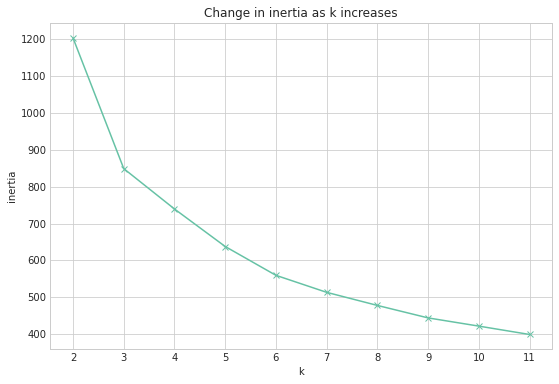

In [52]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(orange_train_scal).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [73]:
KM0 = orange_train.where(orange_train.KM == 0)
KM1 = orange_train.where(orange_train.KM == 1)
KM2 = orange_train.where(orange_train.KM == 2)
KM3 = orange_train.where(orange_train.KM == 3)
KM4 = orange_train.where(orange_train.KM == 4)

KM0 = KM0.dropna()
KM1 = KM1.dropna()
KM2 = KM2.dropna()
KM3 = KM3.dropna()
KM4 = KM4.dropna()

In [76]:
KM4.describe()

,parcelid,bathrooms,bedrooms,square_feet,fips,garages,garage_size,lot_size,has_pool,propertylandusetypeid,year_built,taxvaluedollarcnt,landtaxvaluedollarcnt,log_error,latitude,longitude,KM
count,1.814000e+03,1814.000000,1814.000000,1814.000000,1814.0,1814.0,1814.000000,1814.000000,1814.0,1814.0,1814.00000,1.814000e+03,1.814000e+03,1814.000000,1814.000000,1814.000000,1814.0
mean,1.430604e+07,3.003583,3.627343,2544.082139,6059.0,0.0,521.039691,6008.024807,0.0,261.0,1995.51323,8.056167e+05,4.793201e+05,0.013634,33.662753,-117.753753,4.0
std,1.802537e+05,0.632685,0.699099,743.312998,0.0,0.0,119.534714,5419.069117,0.0,0.0,9.31703,4.265024e+05,3.445011e+05,0.063325,0.131287,0.128260,0.0
min,1.383769e+07,1.000000,1.000000,911.000000,6059.0,0.0,0.000000,880.000000,0.0,261.0,1954.00000,8.704500e+04,1.794200e+04,-0.299544,33.393644,-118.111451,4.0
25%,1.420176e+07,2.500000,3.000000,1963.000000,6059.0,0.0,436.000000,3800.000000,0.0,261.0,1989.00000,5.361880e+05,2.761762e+05,-0.011089,33.566103,-117.838049,4.0
50%,1.435703e+07,3.000000,4.000000,2461.000000,6059.0,0.0,484.000000,5082.000000,0.0,261.0,1996.00000,7.114180e+05,4.190740e+05,0.008342,33.646731,-117.736463,4.0
75%,1.444836e+07,3.500000,4.000000,3009.750000,6059.0,0.0,606.000000,6750.000000,0.0,261.0,2002.00000,9.361582e+05,5.769255e+05,0.032688,33.738087,-117.640752,4.0
max,1.476274e+07,5.000000,5.000000,5494.000000,6059.0,0.0,2720.000000,139392.000000,0.0,261.0,2015.00000,2.989631e+06,2.633609e+06,0.497845,33.937395,-117.554636,4.0


In [70]:
orange_train.describe()

,parcelid,bathrooms,bedrooms,square_feet,fips,garages,garage_size,lot_size,has_pool,propertylandusetypeid,year_built,taxvaluedollarcnt,landtaxvaluedollarcnt,log_error,latitude,longitude,KM
count,7.367000e+03,7367.000000,7367.000000,7367.000000,7367.0,7367.000000,7367.000000,7367.000000,7367.000000,7367.0,7367.000000,7.367000e+03,7.367000e+03,7367.000000,7367.000000,7367.000000,7367.000000
mean,1.419191e+07,2.436541,3.442514,2036.504140,6059.0,0.229673,473.773992,7052.552735,0.229673,261.0,1974.026605,5.399051e+05,3.547769e+05,0.013972,33.719056,-117.833962,2.168725
std,1.988492e+05,0.761337,0.800268,808.429106,0.0,0.420651,156.157358,5478.472926,0.420651,0.0,17.937203,4.069833e+05,3.068117e+05,0.075632,0.127726,0.135716,1.319010
min,1.383453e+07,1.000000,1.000000,653.000000,6059.0,0.000000,0.000000,540.000000,0.000000,261.0,1910.000000,4.006800e+04,1.327500e+04,-0.309399,33.393644,-118.111451,0.000000
25%,1.401945e+07,2.000000,3.000000,1421.000000,6059.0,0.000000,420.000000,4950.000000,0.000000,261.0,1962.000000,2.688755e+05,1.401410e+05,-0.018086,33.628333,-117.948898,1.000000
50%,1.419650e+07,2.500000,3.000000,1860.000000,6059.0,0.000000,460.000000,6360.000000,0.000000,261.0,1972.000000,4.611440e+05,3.114320e+05,0.007320,33.727454,-117.847154,2.000000
75%,1.437377e+07,3.000000,4.000000,2486.000000,6059.0,0.000000,528.000000,7842.000000,0.000000,261.0,1987.000000,7.007610e+05,4.780875e+05,0.035430,33.824151,-117.709998,3.000000
max,1.476274e+07,5.000000,5.000000,5494.000000,6059.0,1.000000,4251.000000,139392.000000,1.000000,261.0,2015.000000,2.989631e+06,2.783873e+06,0.497845,33.945897,-117.554636,4.000000


In [60]:
orange_train.groupby(orange_train.KM == '0').mean()

,parcelid,bathrooms,bedrooms,square_feet,fips,garages,garage_size,lot_size,has_pool,propertylandusetypeid,year_built,taxvaluedollarcnt,landtaxvaluedollarcnt,log_error,latitude,longitude,KM
KM,,,,,,,,,,,,,,,,,
False,1.419191e+07,2.436541,3.442514,2036.50414,6059.0,0.229673,473.773992,7052.552735,0.229673,261.0,1974.026605,539905.097054,354776.86521,0.013972,33.719056,-117.833962,2.168725


In [ ]:
# scaler = sklearn.preprocessing.MinMaxScaler()
# scaler.fit(orange_train[['latitude', 'longitude', 'year_built']])
# # inserts the 4 selected features into the scaler

# orange_train[['scallat', 'scallong', 'scalyr']] = scaler.transform(orange_train[['latitude', 'longitude', 'year_built']])
# orange_validate[['scallat', 'scallong', 'scalyr']] = scaler.transform(orange_validate[['latitude', 'longitude', 'year_built']])
# orange_test[['scallat', 'scallong', 'scalyr']] = scaler.transform(orange_test[['latitude', 'longitude', 'year_built']])

In [ ]:
orange_train.square_feet.groupby(orange_train.locs).mean()

In [ ]:
bins = [1900, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2020]
labels = ['1910s','1920s','1930s','1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', ]
orange_train['year_bin'] = pd.cut(orange_train['year_built'], bins=bins, labels=labels)
orange_validate['year_bin'] = pd.cut(orange_train['year_built'], bins=bins, labels=labels)
orange_test['year_bin'] = pd.cut(orange_train['year_built'], bins=bins, labels=labels)

In [ ]:
sns.barplot(data=orange_train, x='year_bin', y='log_error', hue='locs')
plt.title("Churn and Average Tenure in Months")

In [ ]:
orange_train_neg = orange_train.where(orange_train.log_error < 0)
orange_train_pos = orange_train.where(orange_train.log_error > 0)

In [ ]:
sns.barplot(data=orange_train_pos, x='year_bin', y='log_error', hue='locs')
plt.title("Churn and Average Tenure in Months")

In [ ]:
# does location matter for year matter for? only in early years and also more for negative

In [ ]:
sns.barplot(data=orange_train_neg, x='year_bin', y='log_error', hue='locs')
plt.title("Churn and Average Tenure in Months")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
orange_train.info()

CHECKPOINT

In [ ]:
# dummy_train = pd.get_dummies(orange_train['propertycountylandusecode', 'cluster'])
# dummy_validate = pd.get_dummies(orange_validate['propertycountylandusecode', 'cluster'])
# dummy_test = pd.get_dummies(orange_test['log])

In [ ]:
X_train = orange_train[['bedrooms', 'garages', 'has_pool', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'sqft', 'locs']]
y_train = orange_train.log_error_bin 

X_validate = orange_validate[['bedrooms', 'has_pool','garages',  'bathrooms', 'square_feet',  'lot_size', 'year_built', 'sqft', 'locs']]
y_validate = orange_validate.log_error_bin 

X_test = orange_test[['bedrooms', 'has_pool', 'garages', 'bathrooms', 'square_feet',  'lot_size', 'year_built', 'sqft', 'locs']]
y_test = orange_test.log_error_bin

In [77]:
orange_train['rooms'] = (orange_train['bedrooms'] + orange_train['bathrooms'] + orange_train['garages'])
orange_validate['rooms'] = (orange_validate['bedrooms'] + orange_validate['bathrooms'] + orange_validate['garages'])
orange_test['rooms'] = (orange_test['bedrooms'] + orange_test['bathrooms'] + orange_test['garages'])

In [80]:
orange_validate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3176 entries, 36910 to 13707
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   3176 non-null   float64       
 1   bathrooms                  3176 non-null   float64       
 2   bedrooms                   3176 non-null   float64       
 3   square_feet                3176 non-null   float64       
 4   fips                       3176 non-null   float64       
 5   garages                    3176 non-null   float64       
 6   garage_size                3176 non-null   float64       
 7   lot_size                   3176 non-null   float64       
 8   has_pool                   3176 non-null   object        
 9   propertycountylandusecode  3176 non-null   object        
 10  propertylandusetypeid      3176 non-null   float64       
 11  year_built                 3176 non-null   float64       
 12  t

In [81]:
X_train = orange_train[['bedrooms', 'rooms', 'landtaxvaluedollarcnt', 'garages', 'has_pool', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'taxvaluedollarcnt', 'KM']]
y_train = orange_train.log_error 

X_validate = orange_validate[['bedrooms', 'rooms', 'landtaxvaluedollarcnt', 'garages', 'has_pool', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'taxvaluedollarcnt', 'KM']]
y_validate = orange_validate.log_error

X_test = orange_test[['bedrooms', 'rooms', 'landtaxvaluedollarcnt', 'garages', 'has_pool', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'taxvaluedollarcnt', 'KM']]
y_test = orange_test.log_error

In [82]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

In [83]:
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_validate_scaled = pd.DataFrame(X_validate_scaled, index=X_validate.index, columns=X_validate.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [84]:
from sklearn.feature_selection import SelectKBest, f_regression

f_selector = SelectKBest(f_regression, k=3)

f_selector.fit(X_train_scaled, y_train)

feature_mask = f_selector.get_support()
 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()


In [85]:
f_feature

['garages', 'has_pool', 'square_feet']

In [ ]:
X_train = orange_train[['bedrooms', 'rooms', 'garages', 'has_pool', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'sqft', 'locs']]
y_train = orange_train.log_error_bin 

X_validate = orange_validate[['bedrooms', 'rooms', 'garages', 'has_pool','bathrooms', 'square_feet',  'lot_size', 'year_built', 'sqft', 'locs']]
y_validate = orange_validate.log_error_bin

X_test = orange_test[['bedrooms', 'garages', 'rooms', 'has_pool','bathrooms', 'square_feet',  'lot_size', 'year_built', 'sqft', 'locs']]
y_test = orange_test.log_error_bin

In [ ]:
from sklearn.cluster import KMeans
import sklearn.preprocessing

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(orange_train[['bathrooms','square_feet']])
# inserts the 4 selected features into the scaler

orange_train[['scalbathrooms','scalsquare_feet']] = scaler.transform(orange_train[['bathrooms', 'square_feet']])

In [ ]:
X = orange_train[['scalbathrooms', 'scalsquare_feet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

orange_train['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

In [ ]:
plt.figure(figsize=(9, 6))
pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 20)}).plot(marker='x')
plt.xticks(range(2, 12))
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Change in inertia as k increases')

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(orange_validate[['bathrooms', 'square_feet']])
# inserts the 4 selected features into the scaler

orange_validate[['scalbathrooms', 'scalsquare_feet']] = scaler.transform(orange_validate[['bathrooms', 'square_feet']])

In [ ]:
X = orange_validate[['scalbathrooms', 'scalsquare_feet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

orange_validate['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(orange_test[['bathrooms','square_feet']])
# inserts the 4 selected features into the scaler

orange_test[['scalbathrooms', 'scalsquare_feet']] = scaler.transform(orange_test[['bathrooms', 'square_feet']])

In [ ]:
X = orange_test[['scalbathrooms',  'scalsquare_feet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

orange_test['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

In [ ]:
orange_train

In [ ]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='bedrooms', y='bathrooms', data=orange_train, scatter=True, hue='cluster', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

In [ ]:
sns.barplot(data=orange_train, x='cluster', y='year_built')
plt.title("Land Code w/Cont.")

In [ ]:
orange_train

In [ ]:
dummy_train = pd.get_dummies(orange_train[['propertycountylandusecode', 'cluster']])
dummy_validate = pd.get_dummies(orange_validate[['propertycountylandusecode', 'cluster']])
dummy_test = pd.get_dummies(orange_test[['propertycountylandusecode', 'cluster']])

In [ ]:
X_train

In [ ]:
X_train = orange_train[['sqft', 'has_pool', 'rooms']]
y_train = orange_train[['log_error']]

X_validate = orange_validate[['sqft', 'has_pool', 'rooms']]
y_validate = orange_validate[['log_error']]

X_test = orange_test[['sqft', 'has_pool', 'rooms']]
y_test = orange_test[['log_error']]

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(X_train[['sqft', 'has_pool', 'rooms']])

In [ ]:
X_train[['scalsqft', 'scalhas_pool', 'scalrooms']] = scaler.transform(X_train[['sqft', 'has_pool', 'rooms']]) 
X_validate[['scalsqft', 'scalhas_pool', 'scalrooms']] = scaler.transform(X_validate[['sqft', 'has_pool', 'rooms']]) 
X_test[['scalsqft', 'scalhas_pool', 'scalrooms']] = scaler.transform(X_test[['sqft', 'has_pool', 'rooms']]) 

In [ ]:
# v = pd.DataFrame(data = v)
# v1 = pd.DataFrame(data = v1)
# v2 = pd.DataFrame(data = v2)

In [ ]:
# v.index = X_train.index
# v1.index = X_validate.index
# v2.index = X_test.index

In [ ]:
# X_train = pd.concat([X_train, v], axis=1)
# X_validate = pd.concat([X_validate, v1], axis=1)
# X_test = pd.concat([X_test, v2], axis=1)

In [92]:
X_test_scaled.head()

,bedrooms,rooms,landtaxvaluedollarcnt,garages,has_pool,bathrooms,square_feet,lot_size,year_built,taxvaluedollarcnt,KM
8578,0.50,0.777778,0.211171,3.0,1.0,0.500,0.665152,0.067410,0.704762,0.332309,0.00
29580,0.50,0.333333,0.167456,0.0,0.0,0.250,0.092130,0.026093,0.419048,0.197841,0.25
32000,0.25,0.111111,0.057317,0.0,0.0,0.000,0.010742,0.035765,0.114286,0.053566,0.25
25887,0.50,0.611111,0.208667,2.0,0.0,0.375,0.292708,0.039322,0.723810,0.254448,0.75
3372,0.50,0.333333,0.144691,1.0,0.0,0.000,0.072712,0.047633,0.419048,0.141272,0.25


In [107]:
X_train = X_train_scaled
y_train = orange_train[['log_error']]

X_validate = X_validate_scaled
y_validate = orange_validate[['log_error']]

X_test_scaled = X_test_scaled
y_test = orange_test[['log_error']]

In [108]:
X_validate.head()

,bedrooms,rooms,landtaxvaluedollarcnt,garages,has_pool,bathrooms,square_feet,lot_size,year_built,taxvaluedollarcnt
36910,0.50,0.611111,0.060742,2.0,0.0,0.375,0.282999,0.028952,0.609524,0.113923
9738,1.00,0.833333,0.208981,2.0,0.0,0.375,0.466639,0.044724,0.628571,0.249158
41254,0.25,0.444444,0.023318,2.0,0.0,0.250,0.175584,0.021159,0.704762,0.060867
26782,0.50,0.888889,0.018867,4.0,0.0,0.500,0.224334,0.076772,0.485714,0.054688
5764,0.25,0.333333,0.046266,1.0,0.0,0.250,0.069201,0.004667,0.514286,0.052219


In [109]:
y_train['pred_mean'] = y_train.log_error.mean()
y_validate['pred_mean'] = y_validate.log_error.mean()

rmse_train = mean_squared_error(y_train.log_error, y_train.pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.pred_mean)**(1/2)

print("Baseline RMSE\nTrain/In-Sample: ", round(rmse_train, 4)), 
print("Baseline RMSE\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

Baseline RMSE
Train/In-Sample:  0.0756
Baseline RMSE
Validate/Out-of-Sample:  0.0715


In [110]:
lm = LinearRegression(normalize=True)

lm.fit(X_train, y_train.log_error)

y_train['value_predict_lm'] = lm.predict(X_train)

rmse_train = mean_squared_error(y_train.log_error, y_train.value_predict_lm)**(1/2)

y_validate['value_predict_lm'] = lm.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.value_predict_lm)**(1/2)


printmd("**OLS Linear Regression Performance**")
print("---------------------------------------")
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train, 4))
print("---------------------------------------")
print("RMSE for OLS using LinearRegression\nValidation/Out-of-Sample: ", round(rmse_validate, 4))

**OLS Linear Regression Performance**

---------------------------------------
RMSE for OLS using LinearRegression
Training/In-Sample:  0.0752
---------------------------------------
RMSE for OLS using LinearRegression
Validation/Out-of-Sample:  18798378926.0623


In [111]:
lars = LassoLars(alpha=1.0)

lars.fit(X_train, y_train.log_error)

y_train['pred_lars'] = lars.predict(X_train)

rmse_train = mean_squared_error(y_train.log_error, y_train.pred_lars)**(1/2)

y_validate['pred_lars'] = lars.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.pred_lars)**(1/2)

printmd("**LARS Performance**")
print("---------------------------------------")
print("RMSE for Lars\nTraining/In-Sample: ", round(rmse_train, 4))
print("---------------------------------------")
print("RMSE for Lars\nOut-of-Sample: ", round(rmse_validate, 4))

**LARS Performance**

---------------------------------------
RMSE for Lars
Training/In-Sample:  0.0756
---------------------------------------
RMSE for Lars
Out-of-Sample:  0.0715


In [113]:
pf = PolynomialFeatures(degree=2)
# creates polynomial features to use in model with degree of 3

X_train_degree3 = pf.fit_transform(X_train)
# fit and transform X_train_scaled

# X_validate_degree3 = pf.transform(X_validate)
# X_test_degree3 = pf.transform(X_test)
# transform X_validate_scaled & X_test_scaled

In [114]:
lm3 = LinearRegression(normalize=True)
# creates linear regression model prior to fitting with new polynomial features

lm3.fit(X_train_degree3, y_train.log_error)
# fit and transform polynomial features and target

y_train['value_pred_lm3'] = lm3.predict(X_train_degree3)
# predictions calculated on train

rmse_train = mean_squared_error(y_train.log_error, y_train.value_pred_lm3)**(1/2)
# computes rmse with train

y_validate['value_pred_lm3'] = lm3.predict(X_validate_degree3)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.value_pred_lm3)**(1/2)
# computes predictions/rmse with validate

printmd("**Polynomial Regression Model Performance**")
print("---------------------------------------")
print("RMSE for Polynomial Model \nTraining/In-Sample: ", round(rmse_train, 4)),
print("---------------------------------------")
print("RMSE for Polynomial Model, \nValidation/Out-of-Sample: ", round(rmse_validate, 4))

**Polynomial Regression Model Performance**

---------------------------------------
RMSE for Polynomial Model 
Training/In-Sample:  0.0748
---------------------------------------
RMSE for Polynomial Model, 
Validation/Out-of-Sample:  28518321.5124
